### 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
!pip install kmodes
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/학교/2024-2/경정분 디벨롭/2019 배달데이터 분석/데이터/pj_finaldata.csv")
df = df[['hour_time','humid_val','rain_val', 'temp_val', 'wind_val','day_cmj_mean', 'month', 'weekday', 'DI',
         'kr_cnt', 'snack_cnt', 'cafe_dessert_cnt','pork_jp_cnt', 'fish_cnt', 'chicken_cnt', 'pizza_cnt',
       'asian_western_cnt', 'cn_cnt', 'jokb_bos_cnt', 'steam_soup_cnt','dosirak_cnt', 'fast_cnt']]
df

,hour_time,humid_val,rain_val,temp_val,wind_val,day_cmj_mean,month,weekday,DI,kr_cnt,...,pork_jp_cnt,fish_cnt,chicken_cnt,pizza_cnt,asian_western_cnt,cn_cnt,jokb_bos_cnt,steam_soup_cnt,dosirak_cnt,fast_cnt
0,18,84.0,0.0,24.6,1.2,17.666667,8,2,74.67136,0,...,0,0,0,0,0,0,5,0,0,0
1,16,89.0,0.0,24.1,1.9,18.750000,8,3,74.32851,0,...,0,0,0,0,0,0,1,0,0,0
2,15,79.0,0.0,22.1,0.9,18.708333,8,4,70.18841,0,...,0,0,0,0,0,0,2,0,0,0
3,16,80.0,0.0,21.7,0.8,18.708333,8,4,69.62340,0,...,0,0,0,0,0,0,5,0,0,0
4,10,69.0,0.5,23.6,3.6,9.647059,8,5,71.67016,0,...,0,0,0,0,0,0,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,13,95.0,0.0,20.5,0.1,21.916667,6,3,68.60025,0,...,0,0,0,0,0,0,1,0,0,0
4996,10,79.0,0.0,21.7,2.5,6.583333,6,4,69.55157,0,...,0,0,0,0,0,0,1,0,0,0
4997,10,76.0,0.0,23.6,2.0,24.136364,6,1,72.30464,0,...,0,0,0,0,0,0,1,0,0,0
4998,13,87.0,3.0,20.0,1.9,24.136364,6,1,67.28500,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
df.columns

Index(['hour_time', 'humid_val', 'rain_val', 'temp_val', 'wind_val',
       'day_cmj_mean', 'month', 'weekday', 'DI', 'kr_cnt', 'snack_cnt',
       'cafe_dessert_cnt', 'pork_jp_cnt', 'fish_cnt', 'chicken_cnt',
       'pizza_cnt', 'asian_western_cnt', 'cn_cnt', 'jokb_bos_cnt',
       'steam_soup_cnt', 'dosirak_cnt', 'fast_cnt'],
      dtype='object')

### 변수 변환 및 스케일링

In [ ]:
# 1. 명목형 변수 지정
df['hour_time'] = df['hour_time'].astype(str)
df['weekday'] = df['weekday'].astype(str)
df['month'] = df['month'].astype(str)

categorical_vars = df.select_dtypes(exclude=[np.number]).columns
df_categorical = df[categorical_vars]

In [ ]:
# 2. 연속형 변수 지정 및 스케일링
continuous_vars = df.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[continuous_vars]), columns=continuous_vars)

In [ ]:
# 3. 명목형 변수 데이터프레임 + 연속형 변수 데이터프레임 합치기
df_preprocessed = pd.concat([df_scaled, df_categorical], axis=1)

### k-prototype 실행
- 셀 실행 시간상 최적 k값 찾는 코드 생략
- k=3으로 진행

In [ ]:
k = 3
kproto = KPrototypes(n_clusters=k, init='Huang', random_state=123)
df_preprocessed['cluster'] = kproto.fit_predict(df_preprocessed, categorical=[df_preprocessed.columns.get_loc(col) for col in categorical_vars])

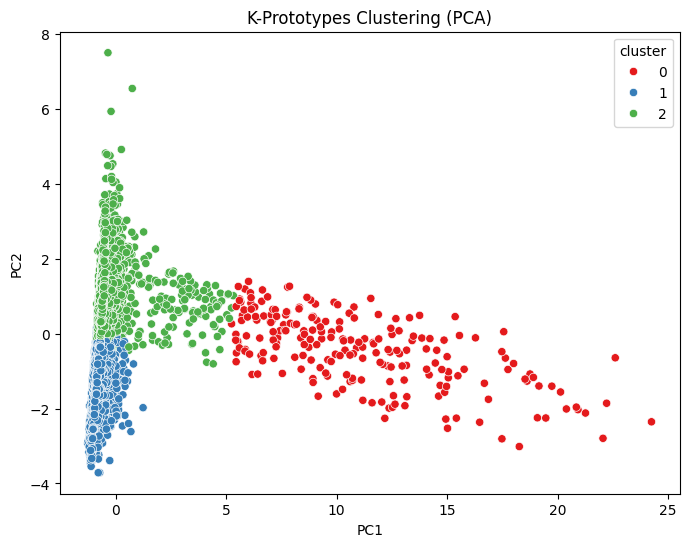

In [ ]:
# PCA를 이용한 2D 시각화
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_preprocessed[continuous_vars])

df_preprocessed['PC1'] = pca_result[:, 0]
df_preprocessed['PC2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_preprocessed, x='PC1', y='PC2', hue='cluster', palette='Set1')
plt.title("K-Prototypes Clustering (PCA)")
plt.show()

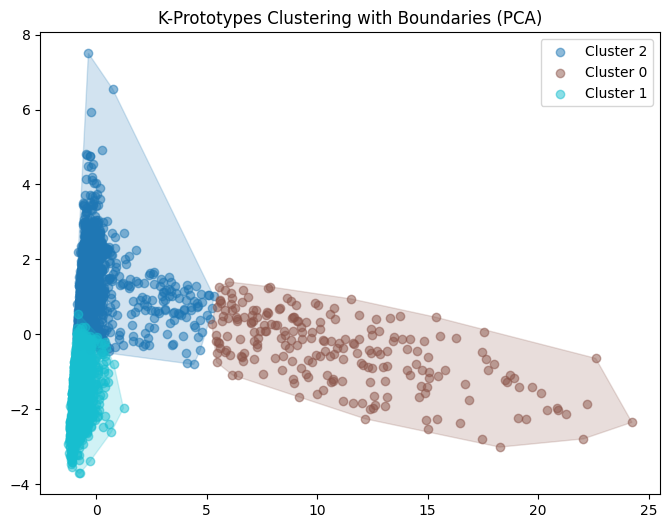

In [ ]:
# Convex Hull을 찾는 함수
def find_hull(df):
    points = df[['PC1', 'PC2']].values
    hull = ConvexHull(points)
    return points[hull.vertices]

# 고유한 클러스터 수에 맞게 컬러맵 생성
num_clusters = df_preprocessed['cluster'].nunique()
cmap = plt.get_cmap("tab10", num_clusters)  # "tab10"은 10가지 색을 제공하는 컬러맵

plt.figure(figsize=(8, 6))

for i, cluster in enumerate(df_preprocessed['cluster'].unique()):
    subset = df_preprocessed[df_preprocessed['cluster'] == cluster]
    color = cmap(i)  # 클러스터별 색상 지정

    # 데이터 점 플로팅
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', color=color, alpha=0.5)

    # Convex Hull 그리기
    hull_points = find_hull(subset)
    plt.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.2)  # 같은 색으로 채우기

plt.title("K-Prototypes Clustering with Boundaries (PCA)")
plt.legend()
plt.show()

In [ ]:
# ----- 원본 데이터와 병합 -----
df['cluster'] = df_preprocessed['cluster']

# ----- 클러스터별 데이터 분리 -----
delivery_cluster0 = df[df['cluster'] == 0]
delivery_cluster1 = df[df['cluster'] == 1]
delivery_cluster2 = df[df['cluster'] == 2]

In [ ]:
delivery_cluster0

,hour_time,humid_val,rain_val,temp_val,wind_val,day_cmj_mean,month,weekday,DI,kr_cnt,...,fish_cnt,chicken_cnt,pizza_cnt,asian_western_cnt,cn_cnt,jokb_bos_cnt,steam_soup_cnt,dosirak_cnt,fast_cnt,cluster
31,11,64.0,0.0,24.3,1.0,14.739130,9,4,72.22748,27,...,1,2,0,0,5,1,4,1,1,0
32,12,70.0,0.0,23.7,1.6,14.739130,9,4,71.91110,31,...,0,4,1,0,1,0,1,9,2,0
33,13,73.0,0.0,23.1,0.5,14.739130,9,4,71.26637,20,...,0,5,0,0,4,2,2,2,0,0
37,17,78.0,0.0,21.4,1.1,14.739130,9,4,69.00508,35,...,7,8,2,0,3,9,3,2,0,0
38,18,77.0,0.0,21.0,0.8,14.739130,9,4,68.30730,34,...,14,19,1,1,5,7,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,22,66.0,0.0,13.8,0.0,9.041667,10,3,57.05692,19,...,8,10,5,5,2,8,5,0,0,0
355,23,64.0,0.0,14.5,0.8,9.041667,10,3,58.08020,16,...,5,10,2,3,3,11,5,0,4,0
356,0,62.0,0.0,15.1,0.0,13.416667,10,4,58.93338,19,...,1,12,1,1,1,9,3,0,1,0
357,1,62.0,0.0,15.8,1.5,13.416667,10,4,59.93004,14,...,5,7,4,5,1,4,2,0,5,0


In [ ]:
delivery_cluster1.describe()

,humid_val,rain_val,temp_val,wind_val,day_cmj_mean,DI,kr_cnt,snack_cnt,cafe_dessert_cnt,pork_jp_cnt,fish_cnt,chicken_cnt,pizza_cnt,asian_western_cnt,cn_cnt,jokb_bos_cnt,steam_soup_cnt,dosirak_cnt,fast_cnt,cluster
count,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.0,2134.0,2134.000000,2134.000000,2134.000000,2134.000000,2134.0
mean,58.914672,0.032099,5.814574,1.302912,24.532070,45.948196,0.151359,0.016401,1.220244,0.170572,0.119025,0.188379,0.061387,0.0,0.0,0.645267,0.031865,0.010309,0.029053,1.0
std,17.143865,0.284422,5.277560,0.985678,11.465335,7.273988,0.427660,0.191750,3.058002,0.461307,0.483079,0.794458,0.294470,0.0,0.0,1.024424,0.188553,0.125832,0.170764,0.0
min,12.000000,0.000000,-9.600000,0.000000,3.652174,26.991200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
25%,46.000000,0.000000,1.900000,0.500000,15.818182,40.686170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
50%,58.000000,0.000000,5.800000,1.100000,23.275000,45.797070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
75%,70.000000,0.000000,9.800000,1.900000,31.375000,51.617045,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.0
max,98.000000,7.500000,18.400000,6.000000,85.166667,62.848720,4.000000,5.000000,27.000000,4.000000,6.000000,12.000000,3.000000,0.0,0.0,9.000000,2.000000,3.000000,2.000000,1.0


In [ ]:
delivery_cluster2.describe()

,humid_val,rain_val,temp_val,wind_val,day_cmj_mean,DI,kr_cnt,snack_cnt,cafe_dessert_cnt,pork_jp_cnt,fish_cnt,chicken_cnt,pizza_cnt,asian_western_cnt,cn_cnt,jokb_bos_cnt,steam_soup_cnt,dosirak_cnt,fast_cnt,cluster
count,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.00000,2647.0
mean,73.630530,0.193238,21.709105,1.205813,17.003501,69.150373,0.970533,0.126936,5.236872,0.182471,0.042690,0.324518,0.039290,0.048734,0.014356,0.527012,0.168115,0.030223,0.06989,2.0
std,15.601362,1.240749,4.529469,0.878039,8.431243,7.048964,2.905263,0.730335,10.319984,0.563727,0.320723,0.886243,0.216404,0.334868,0.173286,1.261353,0.612970,0.226363,0.39939,0.0
min,23.000000,0.000000,5.400000,0.000000,2.416667,42.078160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.0
25%,63.000000,0.000000,18.650000,0.600000,10.833333,63.993920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.0
50%,74.000000,0.000000,22.100000,1.000000,16.166667,69.774933,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.0
75%,86.000000,0.000000,25.100000,1.700000,22.000000,74.379290,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.0
max,98.000000,23.500000,33.700000,5.400000,58.208333,86.795082,25.000000,13.000000,156.000000,6.000000,8.000000,9.000000,3.000000,5.000000,4.000000,10.000000,6.000000,5.000000,6.00000,2.0


In [ ]:
import pandas as pd

# 각 클러스터의 평균값 추출
mean0 = delivery_cluster0.describe().loc['mean']
mean1 = delivery_cluster1.describe().loc['mean']
mean2 = delivery_cluster2.describe().loc['mean']

# 하나의 데이터프레임으로 결합
mean_df = pd.DataFrame([mean0, mean1, mean2], index=['cluster0', 'cluster1', 'cluster2'])
mean_df

,humid_val,rain_val,temp_val,wind_val,day_cmj_mean,DI,kr_cnt,snack_cnt,cafe_dessert_cnt,pork_jp_cnt,fish_cnt,chicken_cnt,pizza_cnt,asian_western_cnt,cn_cnt,jokb_bos_cnt,steam_soup_cnt,dosirak_cnt,fast_cnt,cluster
cluster0,75.041096,0.164384,19.733333,1.276256,15.795464,66.236622,23.502283,7.579909,3.716895,3.123288,6.328767,11.255708,1.963470,2.356164,3.438356,5.831050,2.936073,1.447489,1.296804,0.0
cluster1,58.914672,0.032099,5.814574,1.302912,24.532070,45.948196,0.151359,0.016401,1.220244,0.170572,0.119025,0.188379,0.061387,0.000000,0.000000,0.645267,0.031865,0.010309,0.029053,1.0
cluster2,73.630530,0.193238,21.709105,1.205813,17.003501,69.150373,0.970533,0.126936,5.236872,0.182471,0.042690,0.324518,0.039290,0.048734,0.014356,0.527012,0.168115,0.030223,0.069890,2.0


### 클러스터링 결과 확인

In [ ]:
# 군집 결과 추가
df_clustered = df_preprocessed.copy()

# 군집별 행 개수 계산
cluster_counts = df_clustered['cluster'].value_counts().rename_axis('cluster').reset_index(name='count')

# 수치형 변수 요약 (평균, 표준편차 포함)
numeric_summary = df_clustered.groupby("cluster").mean(numeric_only=True).reset_index()

# 명목형 변수 최빈값 요약
categorical_columns = df_clustered.select_dtypes(include=['object', 'category']).columns
mode_summary_df = df_clustered.groupby("cluster")[categorical_columns].agg(lambda x: x.mode()[0])

# 최종 요약 DataFrame 결합
final_summary = pd.concat([numeric_summary.set_index("cluster"), mode_summary_df], axis=1)
final_summary = final_summary.merge(cluster_counts.set_index("cluster"), left_index=True, right_index=True)

# 결과 출력
print("\n🔹 군집별 수치형 및 명목형 변수 요약:")
final_summary


🔹 군집별 수치형 및 명목형 변수 요약:


,humid_val,rain_val,temp_val,wind_val,day_cmj_mean,DI,kr_cnt,snack_cnt,cafe_dessert_cnt,pork_jp_cnt,...,jokb_bos_cnt,steam_soup_cnt,dosirak_cnt,fast_cnt,PC1,PC2,hour_time,month,weekday,count
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.428687,0.044074,0.533533,0.027740,-0.413874,0.530682,3.943014,3.316331,0.032482,3.095810,...,2.791987,3.251231,2.222815,2.329054,10.933658,-0.429050,1,10,6,219
1,-0.477425,-0.097495,-0.983688,0.056272,0.413871,-0.982226,-0.262293,-0.180200,-0.278358,-0.149047,...,-0.091486,-0.239599,-0.119790,-0.150914,-0.769290,-1.463390,15,11,2,2134
2,0.349430,0.074954,0.748903,-0.047661,-0.299419,0.747960,-0.114767,-0.129101,0.221724,-0.135971,...,-0.157240,-0.075828,-0.087331,-0.071029,-0.284400,1.215277,11,9,4,2647


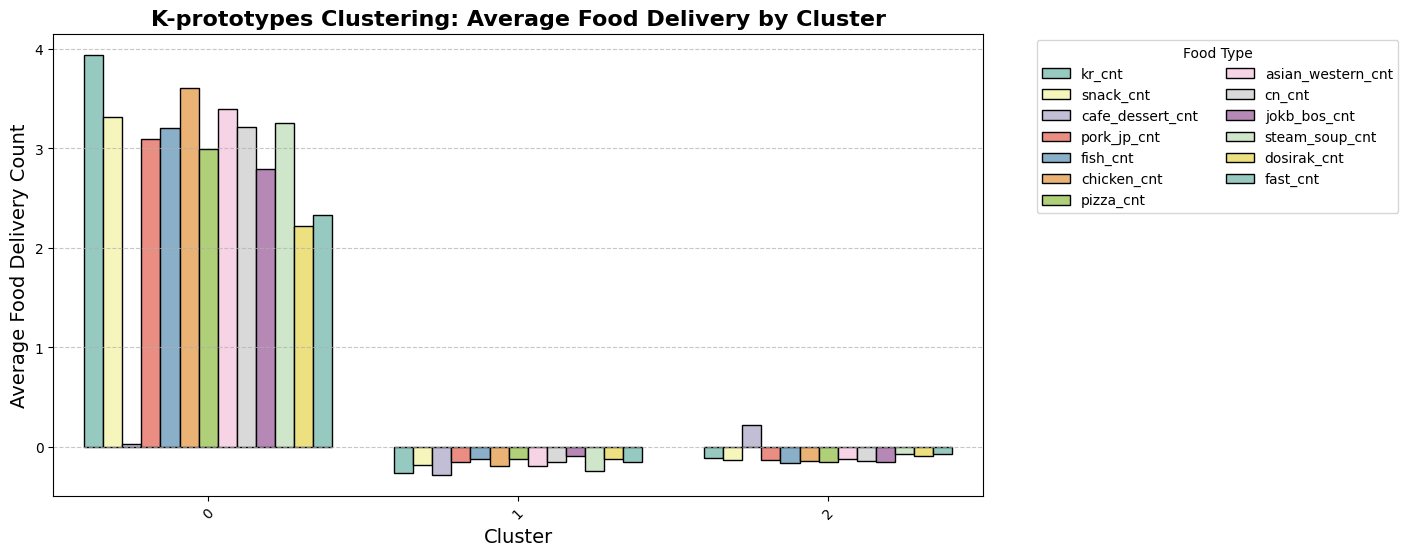

In [ ]:
# 군집별 평균 음식 소비량 요약 (음식 관련 변수만 선택)
food_columns = [col for col in df_clustered.columns if col.endswith('_cnt')]
cluster_summary = df_clustered.groupby('cluster')[food_columns].mean().reset_index()

# Long Format으로 변환
cluster_summary_long = cluster_summary.melt(id_vars=['cluster'],
                                           var_name='Food_Type',
                                           value_name='Average_Count')

# 군집별 음식 소비 막대그래프
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_summary_long, x='cluster', y='Average_Count', hue='Food_Type',
            palette='Set3', edgecolor='black')

# 그래프 설정
plt.title("K-prototypes Clustering: Average Food Delivery by Cluster", fontsize=16, fontweight='bold')
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Average Food Delivery Count", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Food Type', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax = plt.gca()

plt.show()

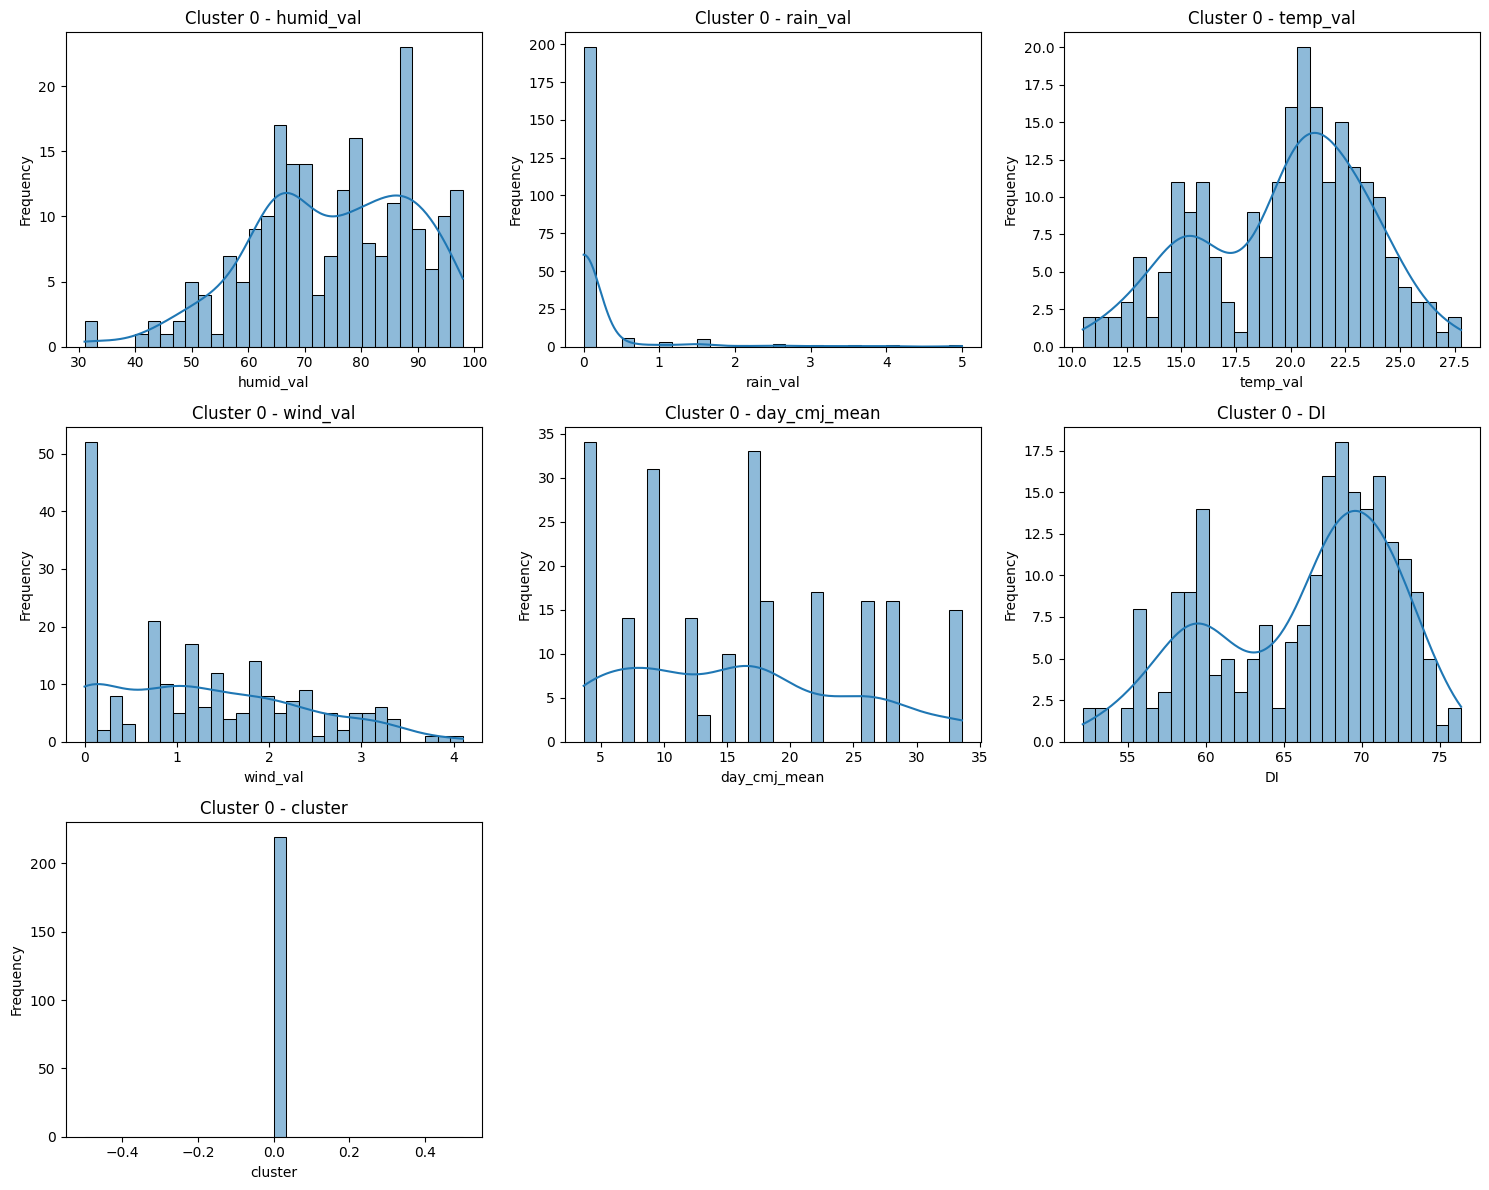

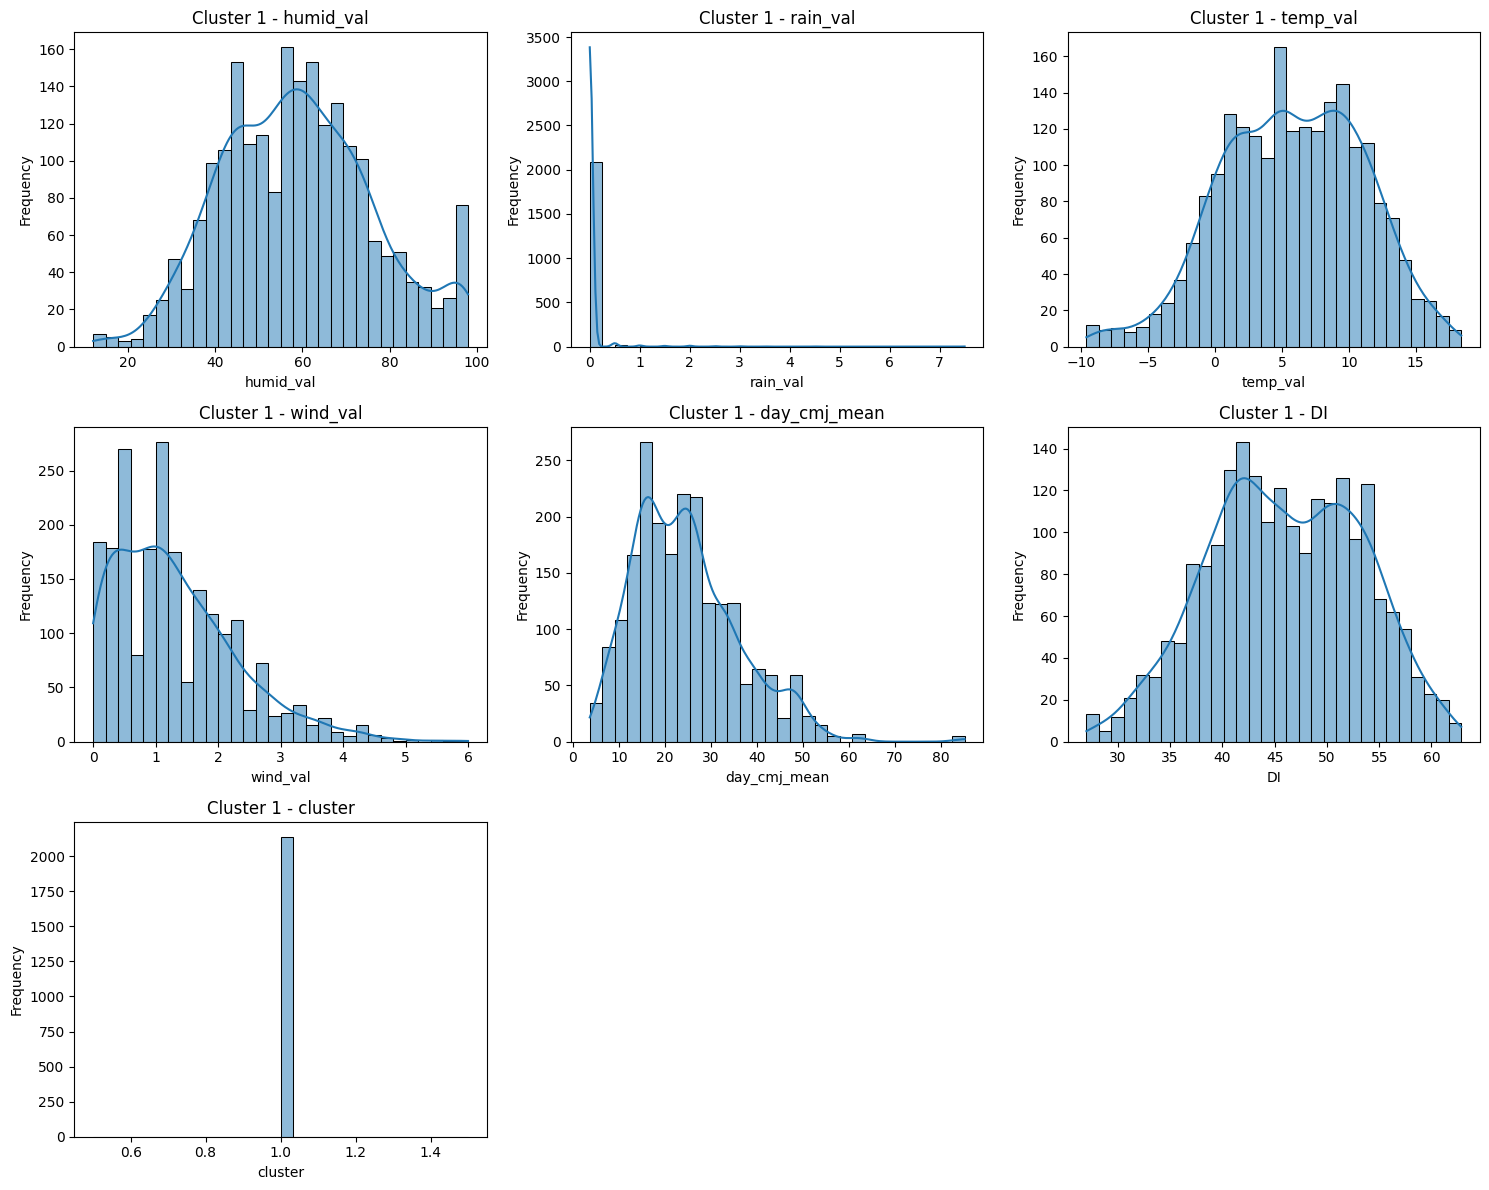

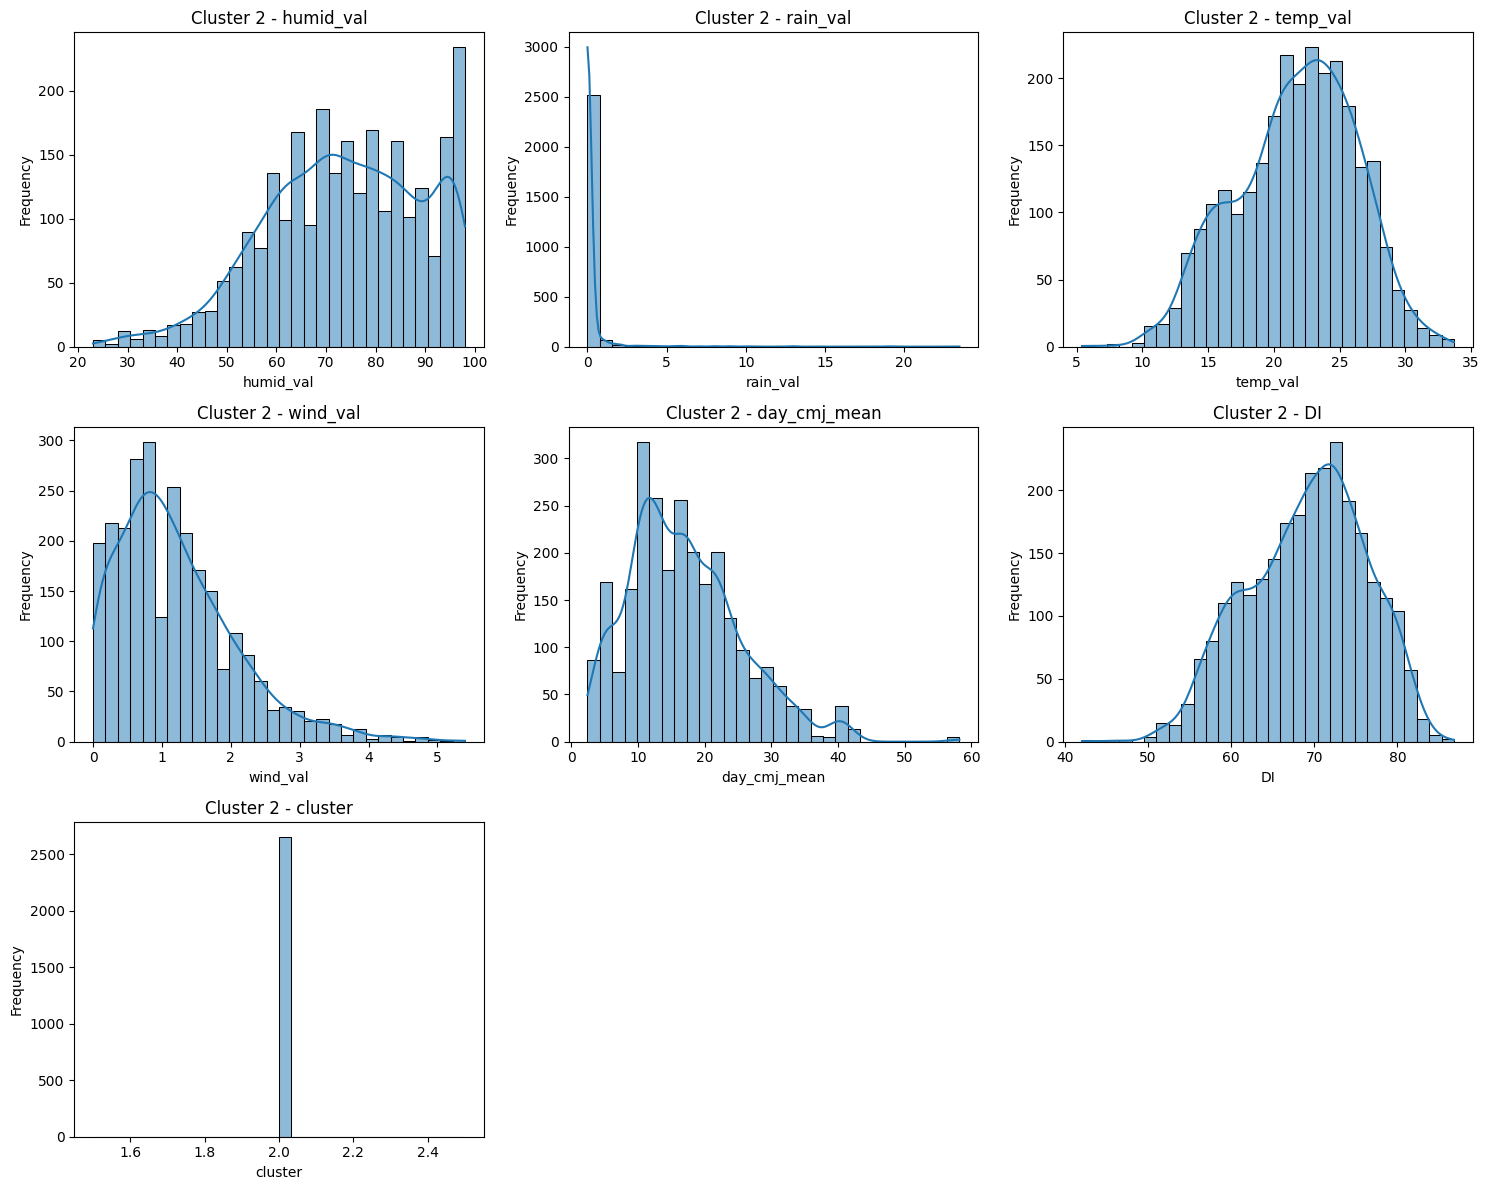

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 클러스터 리스트와 이름
clusters = [delivery_cluster0, delivery_cluster1, delivery_cluster2]
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# 클러스터별로 분포 시각화
for df, name in zip(clusters, cluster_names):
    # 수치형 컬럼 중에서 'cnt'로 끝나지 않는 컬럼만 선택
    num_columns = [col for col in df.select_dtypes(include='number').columns if not col.endswith('cnt')]

    n_cols = 3
    n_rows = (len(num_columns) + n_cols - 1) // n_cols

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    for i, col in enumerate(num_columns, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'{name} - {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


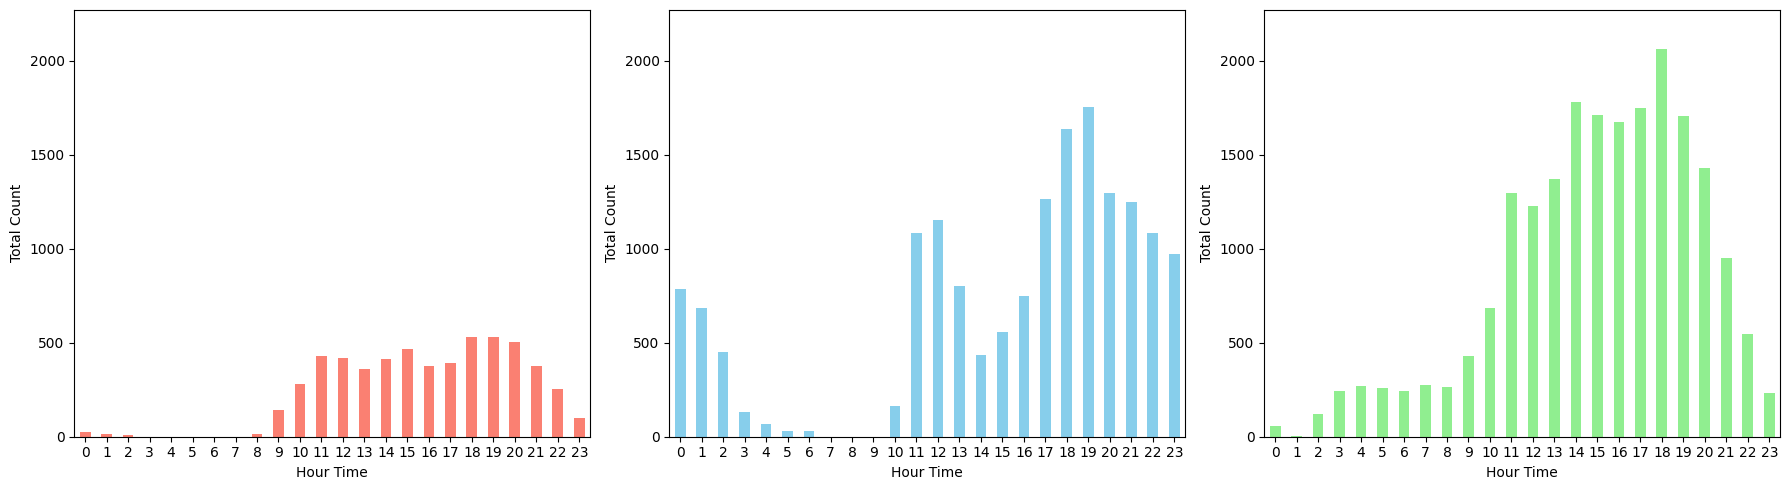

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ⬇️ 클러스터 0과 1의 순서를 바꿔서 그릴 준비
cluster_dfs = [delivery_cluster1, delivery_cluster0, delivery_cluster2]  # 순서: 1, 0, 2
cluster_labels = [1, 0, 2]  # 실제 클러스터 번호
colors = ['salmon', 'skyblue', 'lightgreen']  # 각 클러스터의 색상
hour_range = list(range(24))

hour_sums = []  # 클러스터별 hour_time 총합 저장

# 각 클러스터별 hour_sum 계산
for i, cluster_df in enumerate(cluster_dfs):
    if cluster_df.empty or 'hour_time' not in cluster_df.columns:
        hour_sums.append(pd.Series([0]*24, index=hour_range))
        continue

    cluster_df = cluster_df.copy()
    cluster_df['hour_time'] = pd.to_numeric(cluster_df['hour_time'], errors='coerce').fillna(-1).astype(int)
    cluster_df = cluster_df[cluster_df['hour_time'].between(0, 23)]

    cnt_columns = [col for col in cluster_df.columns if col.endswith('_cnt')]

    if not cnt_columns:
        hour_sums.append(pd.Series([0]*24, index=hour_range))
        continue

    agg_df = cluster_df.groupby('hour_time')[cnt_columns].sum()
    hour_sum = agg_df.sum(axis=1).reindex(hour_range, fill_value=0)
    hour_sums.append(hour_sum)

# ⬇️ y축 통일을 위한 최대값 계산
all_values = pd.concat(hour_sums)
y_max = all_values.max() * 1.1  # 최대값보다 10% 여유
y_min = 0

# ⬇️ 그래프 그리기
plt.figure(figsize=(18, 5))

for i, hour_sum in enumerate(hour_sums):
    plt.subplot(1, 3, i + 1)
    hour_sum.plot(kind='bar', color=colors[i])
    plt.xlabel('Hour Time')
    plt.ylabel('Total Count')
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=0)
    plt.tight_layout()

# plt.suptitle('시간대별 음식 배달 주문 수', fontsize=16, y=1.05)
plt.show()